# 전이학습
해결하고자 하는 문제가 유사하다면 모델을 가져다 쓸 수 있다.

우리가 구하고자 하는게 가벼운 문제라면 다 가져오기 보다 보통 CNN만 가지고 온다. DNN은 직접 만든다.

- VGGNet

VGG16

1. Feature Extraction

- 사전에 학습된 모델을 사용하여 특성추출
 
 학습된 파라미터를 재사용

 분류: 새로 파라미터 학습

include top = DNN

2. Fine Tunnig(미세조정)

- 학습률을 매우 작게 줘야한다. 

 `optimizer = optimizer.Adam(lr=0.0000005)`
 
 이미 웨이트 값이 학습되어있는 상태이기 때문


새로 만드는 것보다 검증된 모델을 사용하는 것이 성능이 더 잘 나온다. 
 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [4]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights =  'imagenet',
                  include_top = False,
                  input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

* Before 'weight' Freezing

In [8]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [11]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

In [12]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 44s 107ms/step - loss: 0.6207 - accuracy: 0.6490 - val_loss: 0.4186 - val_accuracy: 0.8630
Epoch 2/100
100/100 [==============================] - 11s 105ms/step - loss: 0.3945 - accuracy: 0.8250 - val_loss: 0.2569 - val_accuracy: 0.9160
Epoch 3/100
100/100 [==============================] - 11s 105ms/step - loss: 0.2823 - accuracy: 0.8755 - val_loss: 0.2056 - val_accuracy: 0.9200
Epoch 4/100
100/100 [==============================] - 11s 108ms/step - loss: 0.2171 - accuracy: 0.9100 - val_loss: 0.1556 - val_accuracy: 0.9440
Epoch 5/100
100/100 [==============================] - 11s 114ms/step - loss: 0.1692 - accuracy: 0.9350 - val_loss: 0.1348 - val_accuracy: 0.9560
Epoch 6/100
100/100 [==============================] - 11s 112ms/step - loss: 0.1421 - accuracy: 0.9425 - val_loss: 0.0965 - val_accuracy: 0.9720
Epoch 7/100
100/100 [==============================] - 11s 109ms/step - loss: 0.1179 - accuracy: 0.9535 - val_loss: 0.0831 -

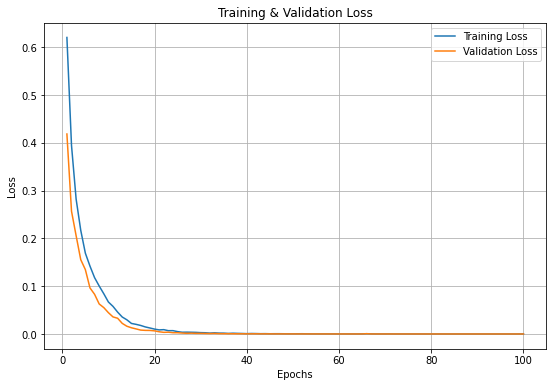

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

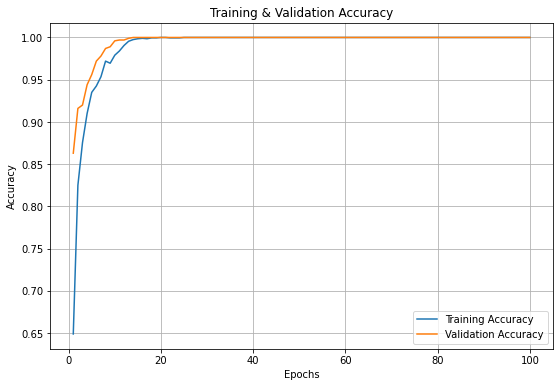

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* test_generator

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [16]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 3s 67ms/step - loss: 0.4003 - accuracy: 0.9250
Loss = 0.40025
Accuracy = 0.92500
